# MeteOsona Data Scrapping

In [334]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import datetime
import logging
import json
import matplotlib.pyplot as plt

## Meteosona metadata scrapping

In [5]:
url = "https://www.meteosona.com/"
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

script_tag = soup.find('script', text=lambda text: text and 'var estacions =' in text)

if script_tag:
    estacions_variable = script_tag.text
    start_index = estacions_variable.find('var estacions = ') + len('var estacions = ')
    end_index = estacions_variable.find(';', start_index)
    estacions_data = estacions_variable[start_index:end_index]
    estacions_dict = json.loads(estacions_data, parse_constant=lambda x: None)
    
else:
    print("Unable to locate the 'estacions' variable on the website. :(")


/var/folders/76/bszhb_2s2k96xxhr9gsw39w80000gn/T/ipykernel_11935/1240470503.py:6: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script_tag = soup.find('script', text=lambda text: text and 'var estacions =' in text)


## Meteosona station scrapping

In [179]:
#create construction dataframe and results dataframe
column_names = ['day', 
                'daily precipitation (l/m2)', 
                'temperature max (C)','temperature min (C)', 'temperature mean (C)',
                'humidity max (%)', 'humidity min (%)', 'humidity mean (%)',
                'wind max (km/h)', 'wind dir', 
                'pressure max (hPa)', 'pressure min (hPa)', 'pressure mean (hPa)',
                'solar irradiation (J/m2)',
                'date','latitude', 'longitude', 'altitude (m)', 'estacio' ]
df_res = pd.DataFrame(columns=column_names)
for estacio_k in estacions_dict.keys():
    estacio=estacions_dict[estacio_k]
    logging.warning(f'Loading estació {estacio["nom"]}...')
    found_estacio=False
    for year in range(2023, 1900, -1):
        found_year=False
        months = [i+1 for i in range(13)]
        months = months[:6] if year==2023 else months
        for month in months:
            url = f'https://www.meteosona.com/estacio/{estacio["nom_url"]}/{str(month)}/{str(year)}/#sectEstacionsResum'
            # Send a GET request to the website
            response = requests.get(url)
            if response.ok:
                soup = BeautifulSoup(response.content, 'html.parser')

                table = soup.find('table', {'id': 'taula_estacio'})

                data = []
                for row in table.find_all('tr'):
                    row_data = []

                    #add html table data
                    for cell in row.find_all('td'):
                        row_data.append(cell.text.strip())
                    if len(row_data)==14:
                        #add date
                        row_data.append(datetime.date(year, month, int(row_data[0])))
                        #add lat, lon & altitude
                        row_data.append(estacio['latitud'])
                        row_data.append(estacio['longitud'])
                        row_data.append(estacio['altitud'])
                        row_data.append(estacio['nom'])
                        data.append(row_data)
                        if not found_estacio:
                            logging.warning('Found data !')
                            found_estacio=True
                        if not found_year:
                            found_year=True

                if len(data)>0:
                    new_rows_df = pd.DataFrame(data, columns=df_res.columns)

                    # Append the new row to the existing dataframe
                    df_res = pd.concat([df_res, new_rows_df], ignore_index=True)
            #if no data found for given year, don't check the next one.
        if not found_year:
            if found_estacio:
                logging.warning(f'last data for {estacio["nom"]} is {year+1}')
            break
    if not found_estacio:
        logging.warning(f'No data found for {estacio["nom"]}')

df_res.to_csv('data/meteosona/all_estacions.csv')

### Sanity checks

In [207]:
for estacio in df_res['estacio'].unique():
    df_test =df_res[df_res['estacio']==estacio].reset_index(drop=True)
    alt=df_test['altitude (m)'].iloc[0]
    lat=df_test['latitude'].iloc[0]
    lon=df_test['longitude'].iloc[0]
    for i in range(len(df_test)):
        assert alt == df_test['altitude (m)'].iloc[i], f'nop: {df_test["altitude (m)"].iloc[i]}'        
        assert lat == df_test['latitude'].iloc[i], f'nop: {df_test["latitude"].iloc[i]}'
        assert lon == df_test['longitude'].iloc[i], f'nop: {df_test["longitude"].iloc[i]}'

### Type Casting

In [287]:
df_res['date'] = pd.to_datetime(df_res['date'])

In [260]:
cols_to_float_cast=[
                'daily precipitation (l/m2)', 
                'temperature max (C)','temperature min (C)', 'temperature mean (C)',
                'humidity max (%)', 'humidity min (%)', 'humidity mean (%)',
                'wind max (km/h)', 
                'pressure max (hPa)', 'pressure min (hPa)', 'pressure mean (hPa)',
                'solar irradiation (J/m2)',
                'latitude', 'longitude', 'altitude (m)']
for column in cols_to_float_cast:
    df_res[column] = pd.to_numeric(df_res[column], errors='coerce').astype(float)


# Quick Data Analysis

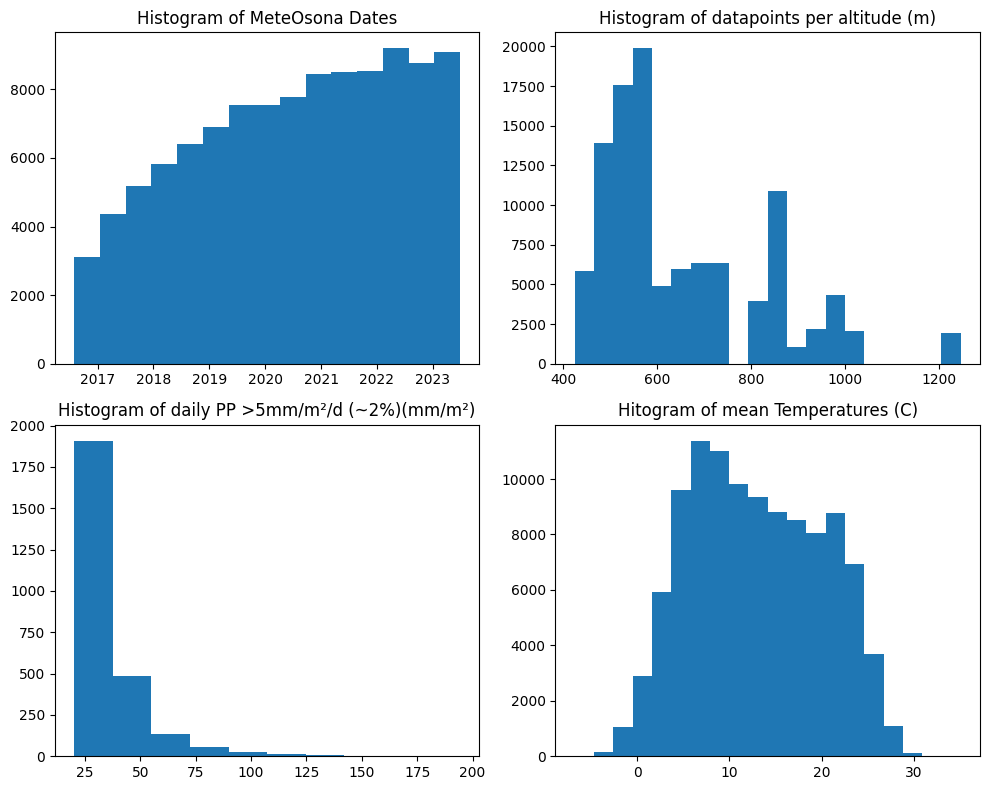

In [294]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(df_res['date'], bins=15)
axs[0, 0].set_title('Histogram of MeteOsona Dates')

axs[0, 1].hist(df_res['altitude (m)'], bins=20)
axs[0, 1].set_title('Histogram of datapoints per altitude (m)')

axs[1, 0].hist(df_res[df_res['daily precipitation (l/m2)']>20]['daily precipitation (l/m2)'], bins=10)
axs[1, 0].set_title(f'Histogram of daily PP >5mm/m²/d (~{int(100*len(df_res[df_res["daily precipitation (l/m2)"]>20])/len(df_res))}%)(mm/m²)')

axs[1, 1].hist(df_res['temperature mean (C)'], bins=20)
axs[1, 1].set_title('Hitogram of mean Temperatures (C)')

fig.tight_layout()
plt.show()

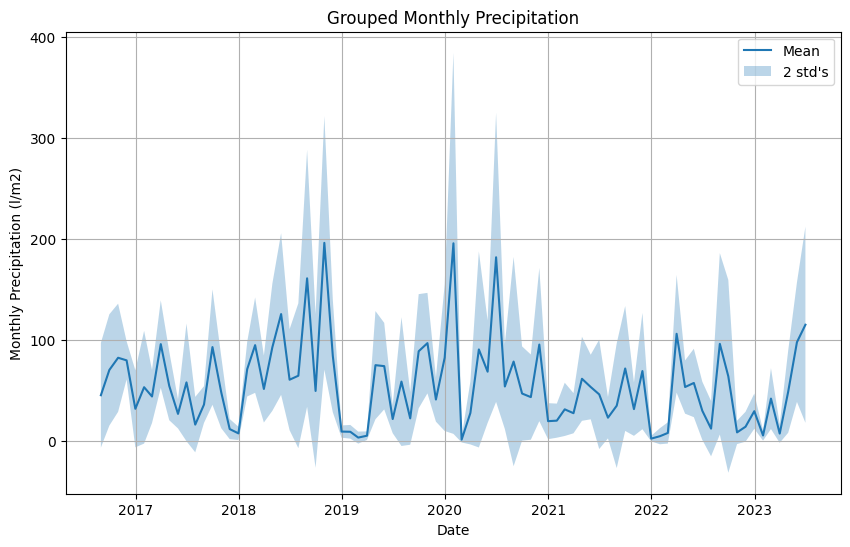

In [332]:
import numpy as np
df = df_res.set_index('date', inplace=False)
monthly_precipitation_bystation = df.groupby('estacio')['daily precipitation (l/m2)'].resample('M').sum()
monthly_precipitation = pd.DataFrame(monthly_precipitation_bystation).droplevel(level=0).resample('M').mean()
monthly_precipitation_std = pd.DataFrame(monthly_precipitation_bystation).droplevel(level=0).resample('M').std()

mean_values = monthly_precipitation['daily precipitation (l/m2)']
std_values = monthly_precipitation_std['daily precipitation (l/m2)']*2

# Plotting the mean and standard deviation as an envelope
plt.figure(figsize=(10, 6))
plt.plot(monthly_precipitation.index, mean_values, label='Mean')
plt.fill_between(monthly_precipitation.index, 
                 mean_values - std_values, 
                 mean_values + std_values,
                 alpha=0.3, label="2 std's")
plt.xlabel('Date')
plt.ylabel('Monthly Precipitation (l/m2)')
plt.title('Grouped Monthly Precipitation')
plt.legend()
plt.grid(True)
plt.show()